In [25]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F
import torch.nn as nn
from sklearn.model_selection import train_test_split

### Посмотрим на датасет.

In [2]:
IMG_ROOT = 'img/720p/'
MASK_ROOT = 'img/mask/'
DATA_ROOT = 'list.csv'

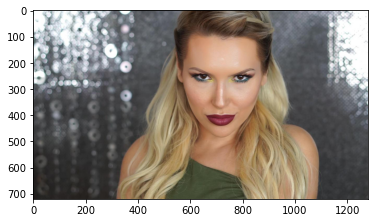

In [3]:
img = plt.imread(IMG_ROOT + '/image00000001.jpg')
plt.imshow(img);

In [4]:
img = plt.imread(MASK_ROOT + 'mask00000001.png')

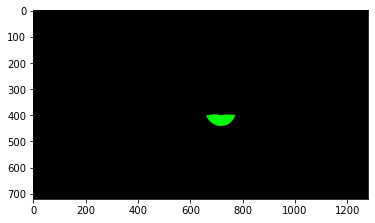

In [5]:
plt.imshow(img);

#### У нас изначальных картинок больше чем масок, значит гдето пропуски или дубли. Посомтрел по маскам дублей нет. В итоге удалил из списка те пары картинка\маска, масок которых нет в папке с изображениями.

In [6]:
df = pd.read_csv(DATA_ROOT)

In [7]:
df.head(5)

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [8]:
df = df[['filename', 'mask']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28594 entries, 0 to 28593
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28594 non-null  object
 1   mask      28594 non-null  object
dtypes: object(2)
memory usage: 446.9+ KB


In [10]:
dd = set(os.listdir(MASK_ROOT))

In [11]:
df_train = df.loc[df['mask'].isin(dd)]

In [12]:
df_train['filename'] = IMG_ROOT + df_train['filename']
df_train['mask'] = MASK_ROOT + df_train['mask']
df_train.reset_index(drop=True, inplace=True)
df_train.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_16540\1187410798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['filename'] = IMG_ROOT + df_train['filename']
C:\Users\user\AppData\Local\Temp\ipykernel_16540\1187410798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['mask'] = MASK_ROOT + df_train['mask']


,filename,mask
0,img/720p/image00000001.jpg,img/mask/mask00000001.png
1,img/720p/image00000002.jpg,img/mask/mask00000002.png
2,img/720p/image00000003.jpg,img/mask/mask00000003.png


In [13]:
df_test = df.loc[~df['mask'].isin(dd)]
df_test['filename'] = IMG_ROOT + df_test['filename']
df_test.drop('mask', inplace=True, axis=1)
df_test.reset_index(drop=True, inplace=True)
df_test.head(3)

C:\Users\user\AppData\Local\Temp\ipykernel_16540\2517149583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['filename'] = IMG_ROOT + df_test['filename']
C:\Users\user\AppData\Local\Temp\ipykernel_16540\2517149583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop('mask', inplace=True, axis=1)


,filename
0,img/720p/image00010716.jpg
1,img/720p/image00010717.jpg
2,img/720p/image00010718.jpg


### Создадим класс для нашего датасета. 
- Так как у нас 1 класс, маску переводим в 1 канал.

In [14]:
class SelfLipDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.imread(self.image_arr[index])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        
        
        mask = cv2.imread(self.label_arr[index], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
        mask = mask[:,:,None]
        mask = np.asarray(mask)
        mask = torch.as_tensor(mask) / 255
        mask = mask.permute(2,0,1)

            
        return (img.float(), mask.float())

    def __len__(self):
        return self.data_len

### Посмотри пример одной пары из датасета

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


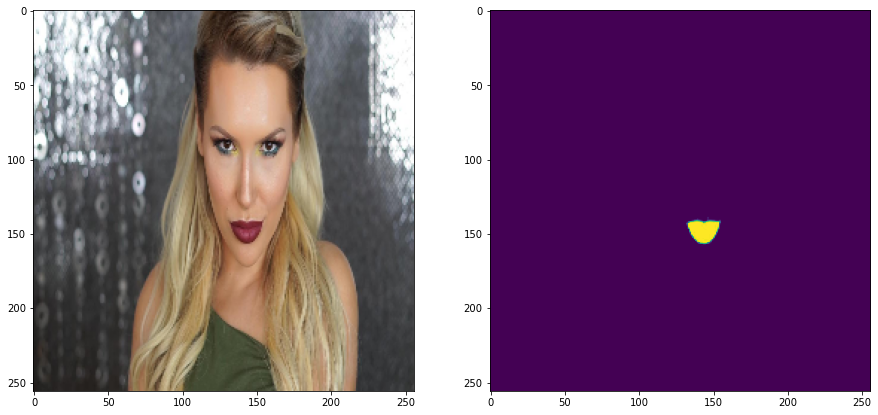

In [15]:
dataset = SelfLipDataset(df_train)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

### Разделим датасет на тест и трейн и обернем каждую часть в наш класс для датасета.

In [16]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df_train, test_size=0.3, random_state=123)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfLipDataset(X_train)
valid_data = SelfLipDataset(X_test)

### Сформируем даталоадеры.

In [17]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
valid_data_loader = DataLoader(
    valid_data,
    batch_size=4,
    shuffle=False
)

torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(0.) tensor(1.)
tensor(0.) tensor(0.7843)


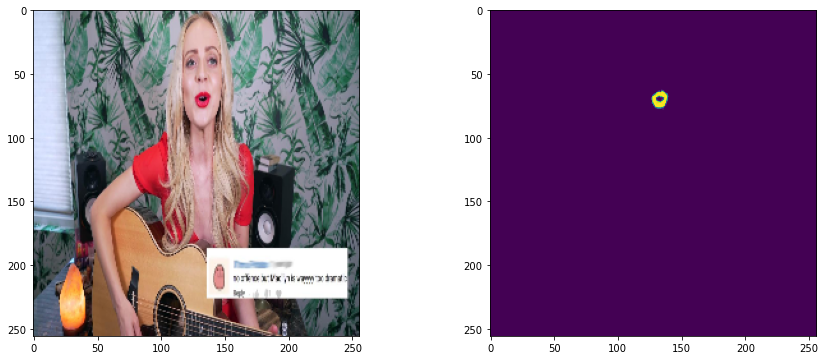

In [18]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0))
    break

## Соберем свою Unet 

In [16]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3,
                                            out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64,
                                            out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128,
                                            out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256,
                                            out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2,
                                         stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024,
                                          out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512,
                                          out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256,
                                          out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
                                             kernel_size=3, stride=2,
                                             padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128,
                                          out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes,
                                kernel_size=3, stride=1,
                                padding=1)
        self.sigmoid = nn.Sigmoid()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels),
            nn.Conv2d(in_channels=out_channels,
                      out_channels=out_channels,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.sigmoid(output)

        return output

### Напишем Функцию потерь

In [18]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 1
        num = targets.size(0)
        probs = logits
        m1 = probs.reshape(num, -1)
        m2 = targets.reshape(num, -1)
        intersection = (m1 * m2)

        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        score = 1 - (score.sum() / num)
        return score

### Напишем функцию для обучения

In [19]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time

def train_model(model, data_loader, optimizer, criterion, epochs):
    # запускаем главный тренировочный цикл
    epoch_losses = []
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        epoch_loss = []

        for batch_idx, (data, labels) in enumerate(data_loader):

            data, labels = data.to(device), labels.to(device)        

            optimizer.zero_grad()
            outputs = model(data)                

            #loss = nn.CrossEntropyLoss(outputs,labels)# - torch.log(DiceLoss(outputs, labels))
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())

            if batch_idx % 200 == 0:
                print(f'batch index : {batch_idx} | loss : {loss.item()}')

        print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
        end_time = time.time()
        print(f'Spend time for 1 epoch: {end_time - start_time} sec')

        epoch_losses.append(epoch_loss)
    return model

### Создадим параметры для сетки и саму сетку

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Umodel = UNet(num_classes=1).to(device)
optimizer = torch.optim.Adam(Umodel.parameters(), lr = 0.001)
criterion = DiceLoss()
epochs = 1

### Обучим сетку

In [25]:
model = train_model(Umodel, train_data_loader, optimizer, criterion, epochs)

batch index : 0 | loss : 0.9957253336906433
batch index : 200 | loss : 0.4732323884963989
batch index : 400 | loss : 0.41358482837677
batch index : 600 | loss : 0.3109068274497986
batch index : 800 | loss : 0.8831951022148132
batch index : 1000 | loss : 0.5001978874206543
batch index : 1200 | loss : 0.2801307439804077
batch index : 1400 | loss : 0.2759188413619995
batch index : 1600 | loss : 0.3446996808052063
batch index : 1800 | loss : 0.19434738159179688
batch index : 2000 | loss : 0.2886941432952881
batch index : 2200 | loss : 0.25026726722717285
batch index : 2400 | loss : 0.23467493057250977
Epoch 1, loss:  0.3356028149326483
Spend time for 1 epoch: 1255.8024971485138 sec


### Сохраним сетку

In [26]:
torch.save(model, 'models')
model = torch.load('models')

### Проверим визуальный ответ

In [27]:
model.eval();

C:\Users\user\AppData\Local\Temp\ipykernel_20028\71883182.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(zz[i])


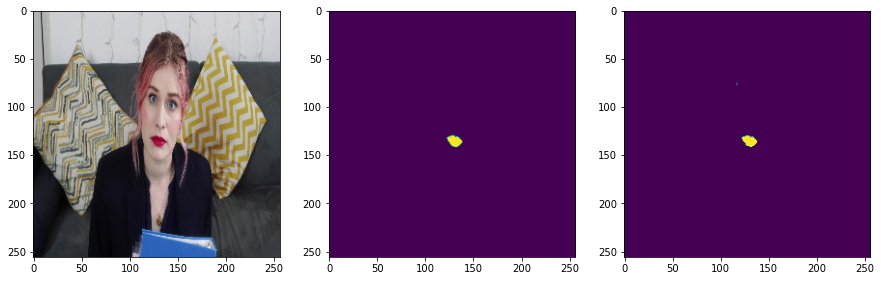

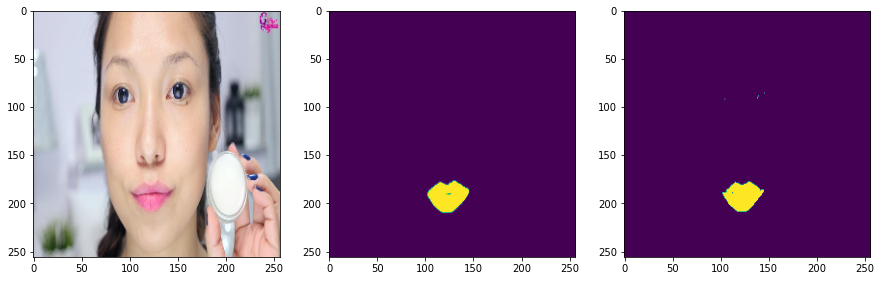

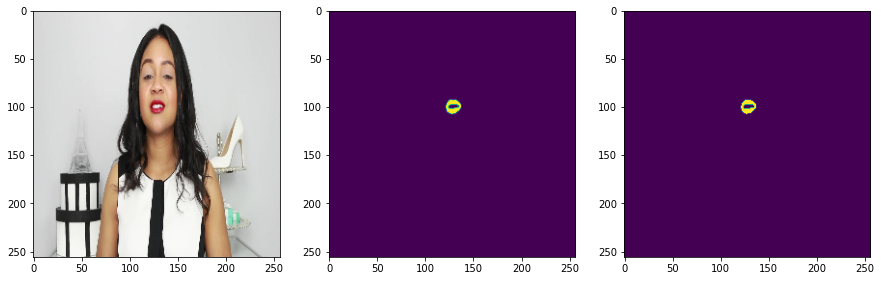

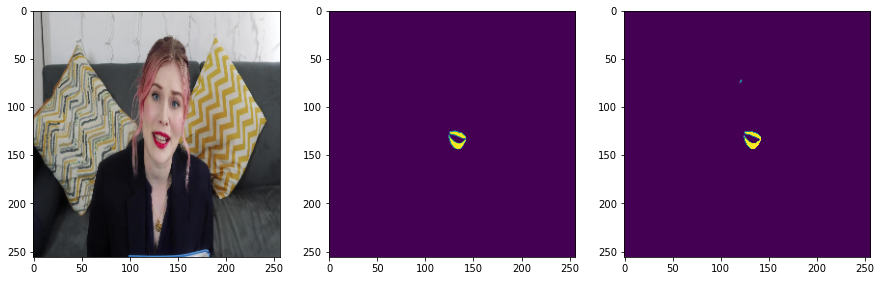

In [28]:
for data in valid_data_loader:
    images, labels = data
    zz = model(images.to(device)).to('cpu')
    for i in range(4):        
        pred = torch.tensor(zz[i])
        fig, ax = plt.subplots(1, 3, figsize=(15, 6))
        ax[0].imshow(images[i].permute(1, 2, 0))
        ax[1].imshow(labels[i].permute(1, 2, 0))
        ax[2].imshow(pred.permute(1, 2, 0))
        plt.show()
    break

### Теперь попробуем взять предобученную сетку из спец модуля.

In [21]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet50'
segmodel = smp.Unet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256]) torch.Size([1, 256, 256])


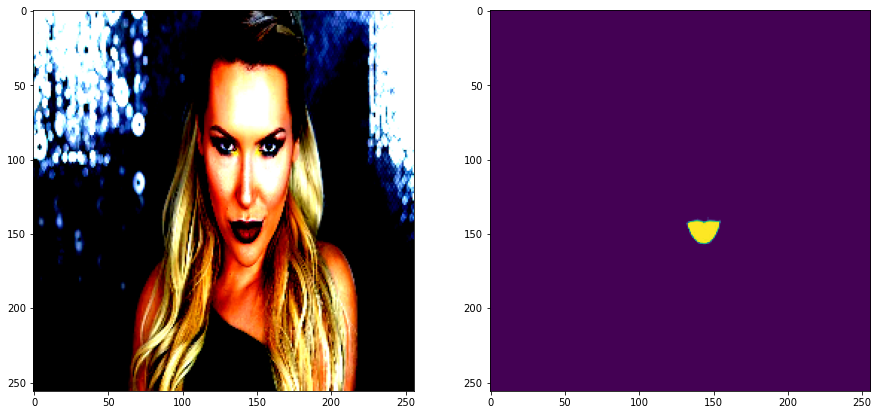

In [22]:
dataset = SelfLipDataset(df_train, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0))
plt.show()

In [26]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df_train, test_size=0.3, random_state=123)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfLipDataset(X_train,
                                preprocessing=preprocess_input)
test_data = SelfLipDataset(X_test,
                               preprocessing=preprocess_input)

In [27]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

In [28]:
criterion = DiceLoss()
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [34]:
model = train_model(segmodel, train_data_loader, optimizer, criterion, epochs=1)

batch index : 0 | loss : 0.9938750863075256
batch index : 200 | loss : 0.2444394826889038
batch index : 400 | loss : 0.21989011764526367
batch index : 600 | loss : 0.1832788586616516
batch index : 800 | loss : 0.17964565753936768
batch index : 1000 | loss : 0.18764889240264893
batch index : 1200 | loss : 0.17814069986343384
batch index : 1400 | loss : 0.19064807891845703
batch index : 1600 | loss : 0.16378474235534668
batch index : 1800 | loss : 0.179548442363739
batch index : 2000 | loss : 0.1869032382965088
batch index : 2200 | loss : 0.18421196937561035
batch index : 2400 | loss : 0.17209815979003906
Epoch 1, loss:  0.23045405478263684
Spend time for 1 epoch: 796.742035150528 sec


In [35]:
torch.save(model, 'Unet-resnet50')
model = torch.load('Unet-resnet50')

In [36]:
model.eval();

C:\Users\user\AppData\Local\Temp\ipykernel_20028\2236029902.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(zz[i])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


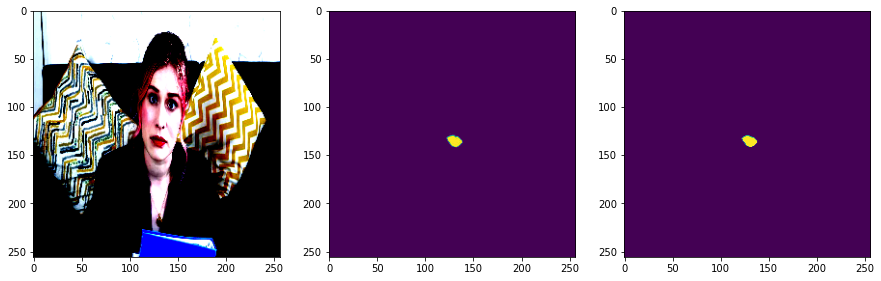

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


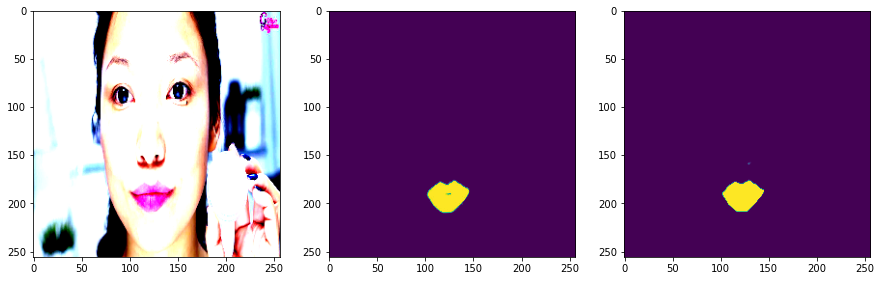

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


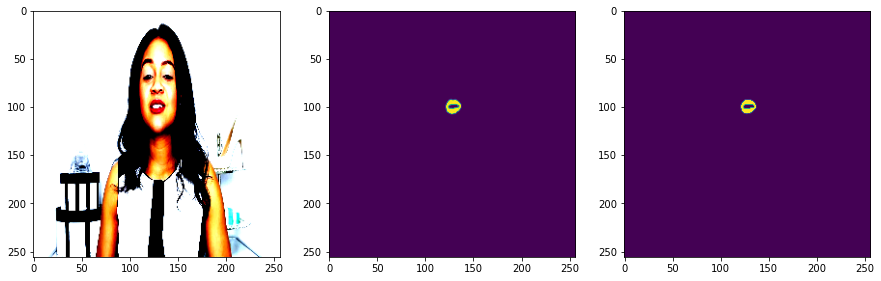

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


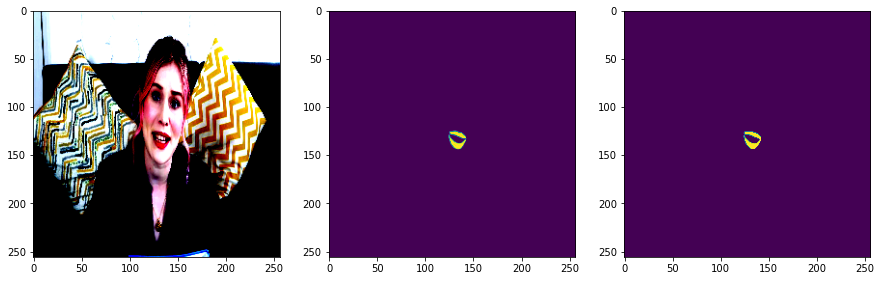

In [37]:
for data in test_data_loader:
    images, labels = data
    zz = model(images.to(device)).to('cpu')
    for i in range(4):        
        pred = torch.tensor(zz[i])
        fig, ax = plt.subplots(1, 3, figsize=(15, 6))
        ax[0].imshow(images[i].permute(1, 2, 0))
        ax[1].imshow(labels[i].permute(1, 2, 0))
        ax[2].imshow(pred.permute(1, 2, 0))
        plt.show()
    break

### Попробуем еще модельку

In [38]:
BACKBONE = 'mobilenet_v2'
segmodel = smp.PSPNet(BACKBONE, classes=1, activation='sigmoid').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')
criterion = DiceLoss()
optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\user/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [39]:
model = train_model(segmodel, train_data_loader, optimizer, criterion, epochs=1)

batch index : 0 | loss : 0.991183340549469
batch index : 200 | loss : 0.3111598491668701
batch index : 400 | loss : 0.30867576599121094
batch index : 600 | loss : 0.28518128395080566
batch index : 800 | loss : 0.265842080116272
batch index : 1000 | loss : 0.2846483588218689
batch index : 1200 | loss : 0.33093684911727905
batch index : 1400 | loss : 0.2517359256744385
batch index : 1600 | loss : 0.28430795669555664
batch index : 1800 | loss : 0.2666183114051819
batch index : 2000 | loss : 0.32595038414001465
batch index : 2200 | loss : 0.33654868602752686
batch index : 2400 | loss : 0.2738696336746216
Epoch 1, loss:  0.29361825071877723
Spend time for 1 epoch: 476.4572591781616 sec


C:\Users\user\AppData\Local\Temp\ipykernel_16540\1912777669.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(zz[i])
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


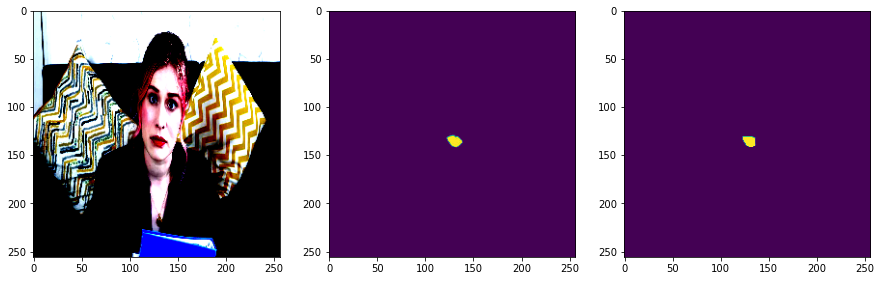

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


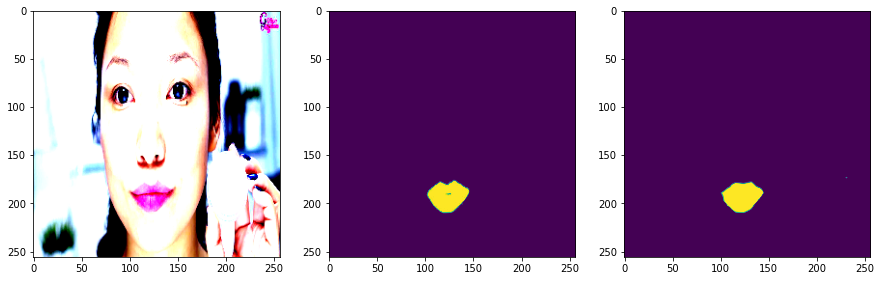

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


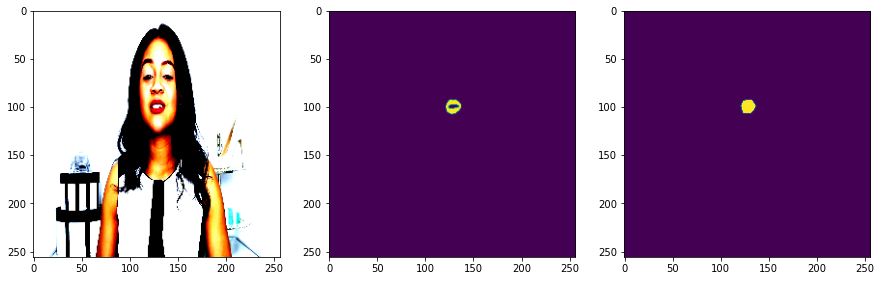

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


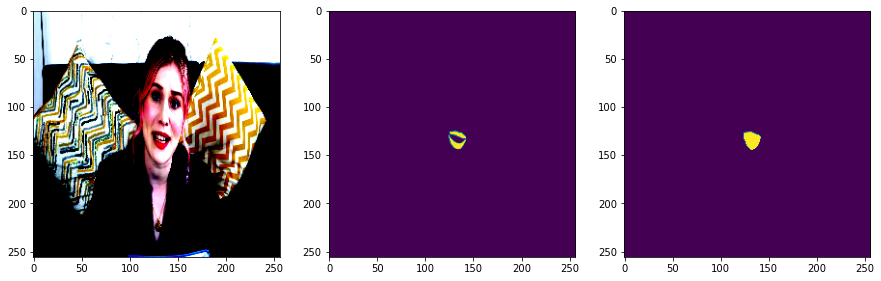

In [40]:
model.eval()
for data in test_data_loader:
    images, labels = data
    zz = model(images.to(device)).to('cpu')
    for i in range(4):        
        pred = torch.tensor(zz[i])
        fig, ax = plt.subplots(1, 3, figsize=(15, 6))
        ax[0].imshow(images[i].permute(1, 2, 0))
        ax[1].imshow(labels[i].permute(1, 2, 0))
        ax[2].imshow(pred.permute(1, 2, 0))
        plt.show()
    break